In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import datetime
import matplotlib.pyplot as plt
from tiingo import TiingoClient
import os
import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters
from dateutil.relativedelta import relativedelta
import io
import math
%matplotlib inline

In [83]:
class Signals():
    """
    Signal library to provide graphical analysis of various market symbols
    
    Parameters
    ----------
    symbol : str
        str representing stock symbol
        
    Attributes
    ----------
    data : pd.DataFrame:
        DataFrame of historical data of this given symbol using TIINGO
    returns_mean : total mean of the returns for historical data
    returns_std : total standard deviation of the returns for historical data
    normal_returns : lambda function representing PDF(x) where x represents some decimal based daily return
    symbol : str
        str representing stock symbol
    """
    def __init__(self, symbol):
        # Matplotlib Setup
        register_matplotlib_converters()
        
        # TIINGO Setup
        config = {}
        config['api_key'] = os.getenv('TINGO_SECRET')
        client = TiingoClient(config)
        self.symbol = symbol
        resp = client.get_ticker_price(
            self.symbol, 
            fmt='csv', 
            startDate=datetime.datetime.today() - relativedelta(years=5),
            endDate=datetime.datetime.today()
        )
        
        self.data = pd.read_csv(io.StringIO(resp))
        f = lambda col: datetime.datetime.strptime(col, '%Y-%m-%d')
        self.data['date'] = self.data['date'].apply(f)
        self.data.index = self.data['date']
        
        # Calculate Averages and Returns
        self.data['avg'] = (self.data['close'] + self.data['low'] + self.data['high']) / 3
        self.data['returns'] = (self.data['open'] - self.data['close']) / self.data['open']
        self.lognorm = lambda x: scipy.stats.lognorm(x, loc=self.data['avg'].mean(), scale=self.data['avg'].std())
            
    def buy_call_prob(self, x: float, ndays: int) -> float:
        """
        Predicts probability that a buy call with breakthrough x will be profitable. Only usable for tomorrows
        closing price at the moment. 
        
        Algorithm
        ----------
        We calculate the CDF of daily returns for this stock throughout the past five years. We assume
        this probability is normally distributed. 
        
        We then find the return (percent change), xhat needed to 
        turn the current closing price to x. We then return the probability of tomorrow's close return (y)
        being greater than xhat, or CDF(y > xhat), also representable as 1 - CDF(xhat)
        
        x : float
            1 - CDF(xhat), or the probability the stock will be greater than x price during tomorrows return
        """
        mu = self.data['returns'].mean()
        std = self.data['returns'].std()
        
        total_mu = mu * ndays
        total_std = math.sqrt(math.pow(std, 2) * ndays)
        xhat = (x - self.data['close'][-1]) / self.data['close'][-1]
        return 1 - stats.norm.cdf(xhat, loc=total_mu, scale=total_std)
    
    def buy_put_prob(self, x: float, ndays: int) -> float:
        """
        Predicts probability that a buy put with breakthrough x will be profitable. Only usable for tomorrows
        closing price at the moment. 
        
        Algorithm
        ----------
        We calculate the CDF of daily returns for this stock throughout the past five years. We assume
        this probability is normally distributed. 
        
        We then find the return (percent change), xhat needed to 
        turn the current closing price to x. We then return the probability of tomorrow's close return (y)
        being less than xhat, or CDF(y < xhat), also representable as CDF(xhat)
        
        Parameters
        ----------
        x : float
            CDF(xhat), or the probability the stock will be less than x price during tomorrows return
        """
        mu = self.data['returns'].mean()
        std = self.data['returns'].std()
        
        total_mu = mu * ndays
        total_std = math.sqrt(math.pow(std, 2) * ndays)
        xhat = (x - self.data['close'][-1]) / self.data['close'][-1]
        return stats.norm.cdf(xhat, loc=total_mu, scale=total_std)
    
    def all_indicators(self, start_timeframe, ndays_ema_short=5, ndays_ema_long=15, macd_ndays=9, cci_ndays=7): 
        """
        Graphically displays CCI, MACD, EMA, and a daily returns normal distribution
        
        Parameters
        ----------
        start_timeframe : datetime obj
            We will only graphically show results ranging from this start time frame to current date
        ndays_ema_short : int
            int representing the number of days for the faster/shorter exponential moving average window.
        ndays_ema_long : int
            int representing the number of days for the slower/longer exponential moving average window.
        macd_ndays : int
            int representing number of days to smooth the macd signal line which is the difference between 
            ema_short and ema_long
        cci_ndays : int
            int representing number of days for the cci simple moving average window used to calculate means and
            standard deviations
        """
        show = self.data.loc[start_timeframe:datetime.datetime.today()]
        plt.rcParams['figure.figsize'] = [20, 20]
        
        # Exponential Moving Average
        plt.subplot(311)
        plt.title('{0} day vs {1} day Exponential Moving Averages'.format(ndays_ema_short, ndays_ema_long))

        ema_short = show['avg'].ewm(span=ndays_ema_short).mean()
        ema_long = show['avg'].ewm(span=ndays_ema_long).mean()
        
        plt.plot(show['avg'], label=self.symbol, color='green')
        plt.plot(ema_short, label='EMA {0} days'.format(ndays_ema_short), color='blue')
        plt.plot(ema_long, label='EMA {0} days'.format(ndays_ema_long), color='red')
        plt.legend()
        
        # Moving Average Convergence Divergence
        plt.subplot(312)
        plt.title('Moving Average Convergence Divergence (MACD)')

        macd = ema_short - ema_long
        signal_line_macd = macd.ewm(span=macd_ndays).mean()
        
        plt.plot(macd, label=self.symbol + ' macd', color='blue')
        plt.plot(signal_line_macd, label='signal line', color='green')
        plt.legend()
        
        # Commodity Channel Index
        plt.subplot(313)
        plt.title('Commodity Channel Index (CCI)')

        sma = show['avg'].rolling(window=cci_ndays).mean()
        std = show['avg'].rolling(window=cci_ndays).std()
        cci = (show['avg'] - sma) / (0.015 * std)
        
        plt.plot(show['avg'].index, [100]*len(show['close'].index), label='bullish', linestyle=':', color='red')
        plt.plot(show['avg'].index, [-100]*len(show['close'].index), label='bearish', linestyle=':', color='blue')
        plt.plot(show['close'].index, [0]*len(show['close'].index), label='threshold', linestyle=':', color='blue')
        plt.plot(cci, label='cci', color='magenta')   
        plt.legend()
        plt.show()
        
        # Volume Chart
        plt.rcParams['figure.figsize'] = [20, 10]
        plt.legend('Volume')
        plt.bar(show.index, show['volume'])
        plt.show()
        
        # Normal Distribution of Returns
        # plt.rcParams['figure.figsize'] = [10, 5]
        # plt.title('Daily Returns Normal Distribution')
        # x = np.linspace(min(self.data['returns']), max(self.data['returns']), 10000)
        # plt.plot(x, [stats.norm.pdf(k) for k in x])
        # plt.show()
    

In [92]:
symbols = ['PYPL', 'AAPL', 'BB', 'T', 'TSLA', 'SPY', 'FB', 'GE', 'BBY', 'INTC', 'VZ', 'FIT']
signals = {symbol: Signals(symbol) for symbol in symbols}

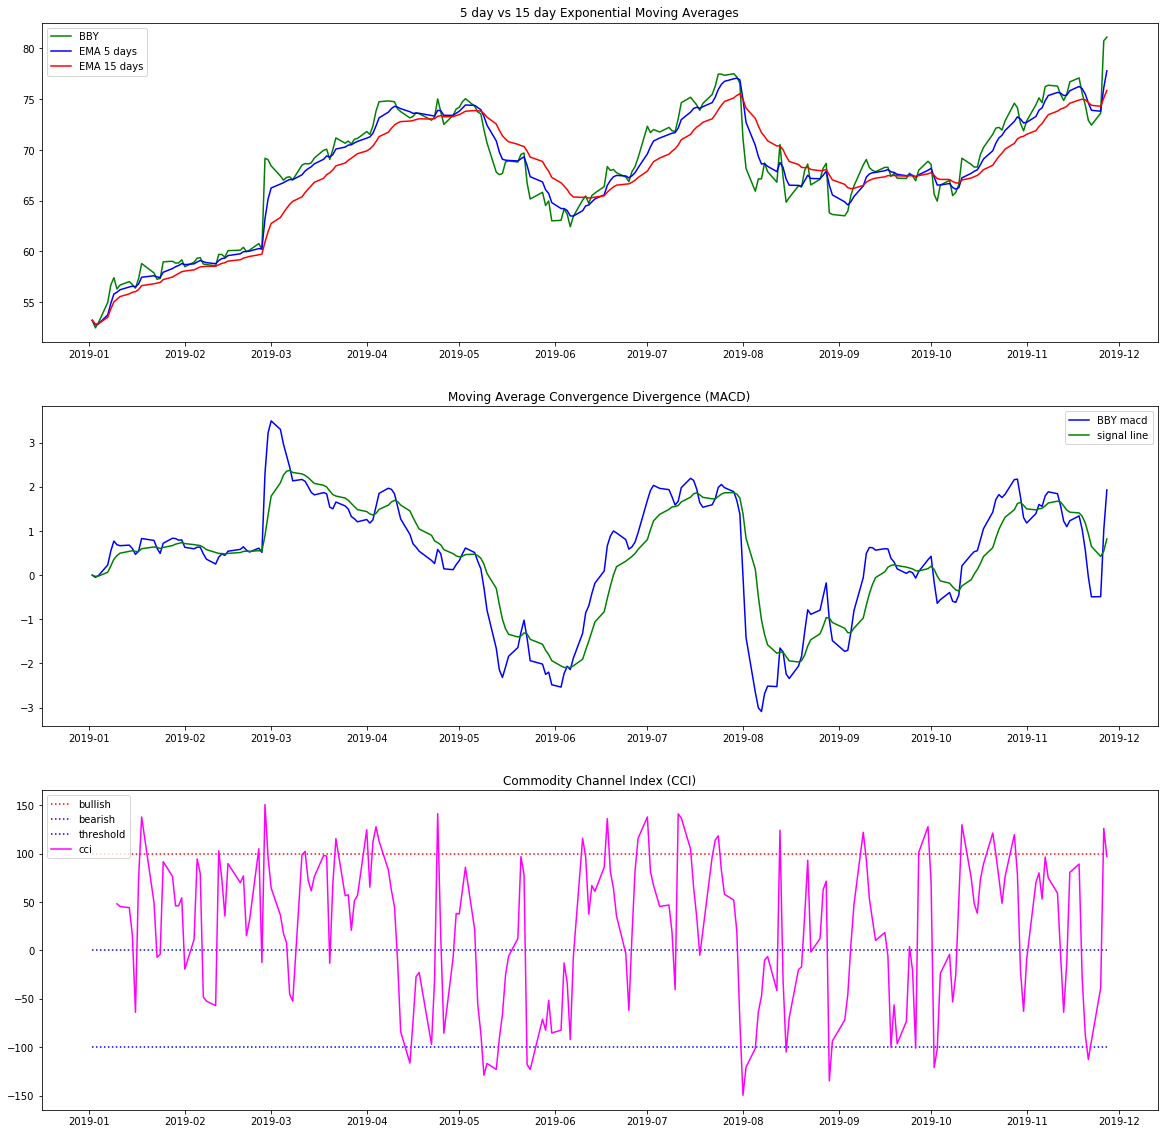

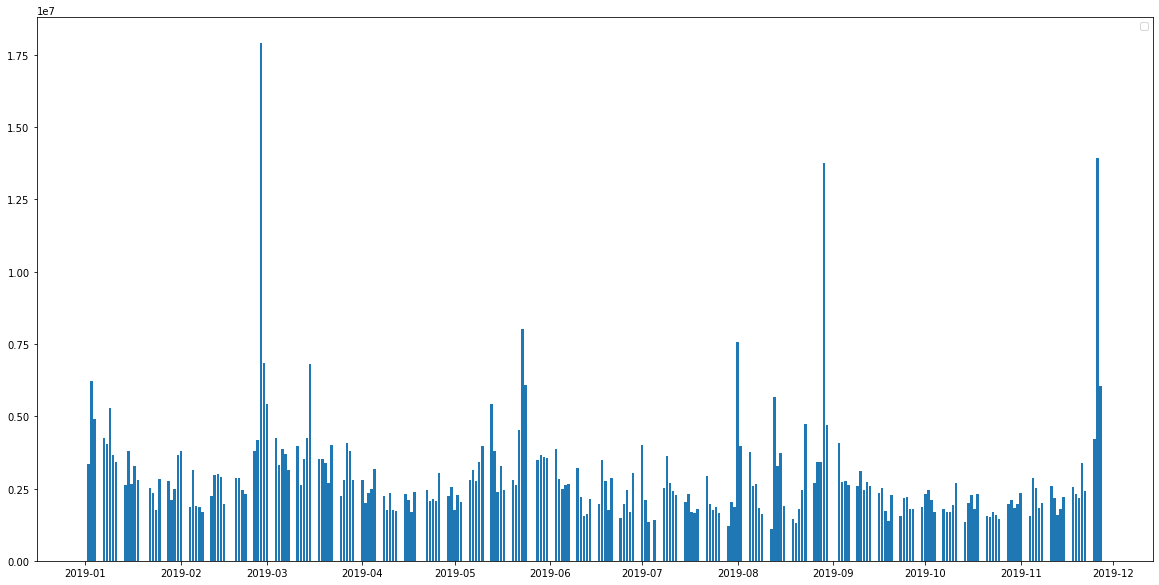

In [93]:
signals['BBY'].all_indicators(datetime.datetime(2019, 1, 1))